In [1]:
!pip install music21

In [2]:
!pip install midiutil

Enter a Wolfram rule number (0–255):  20


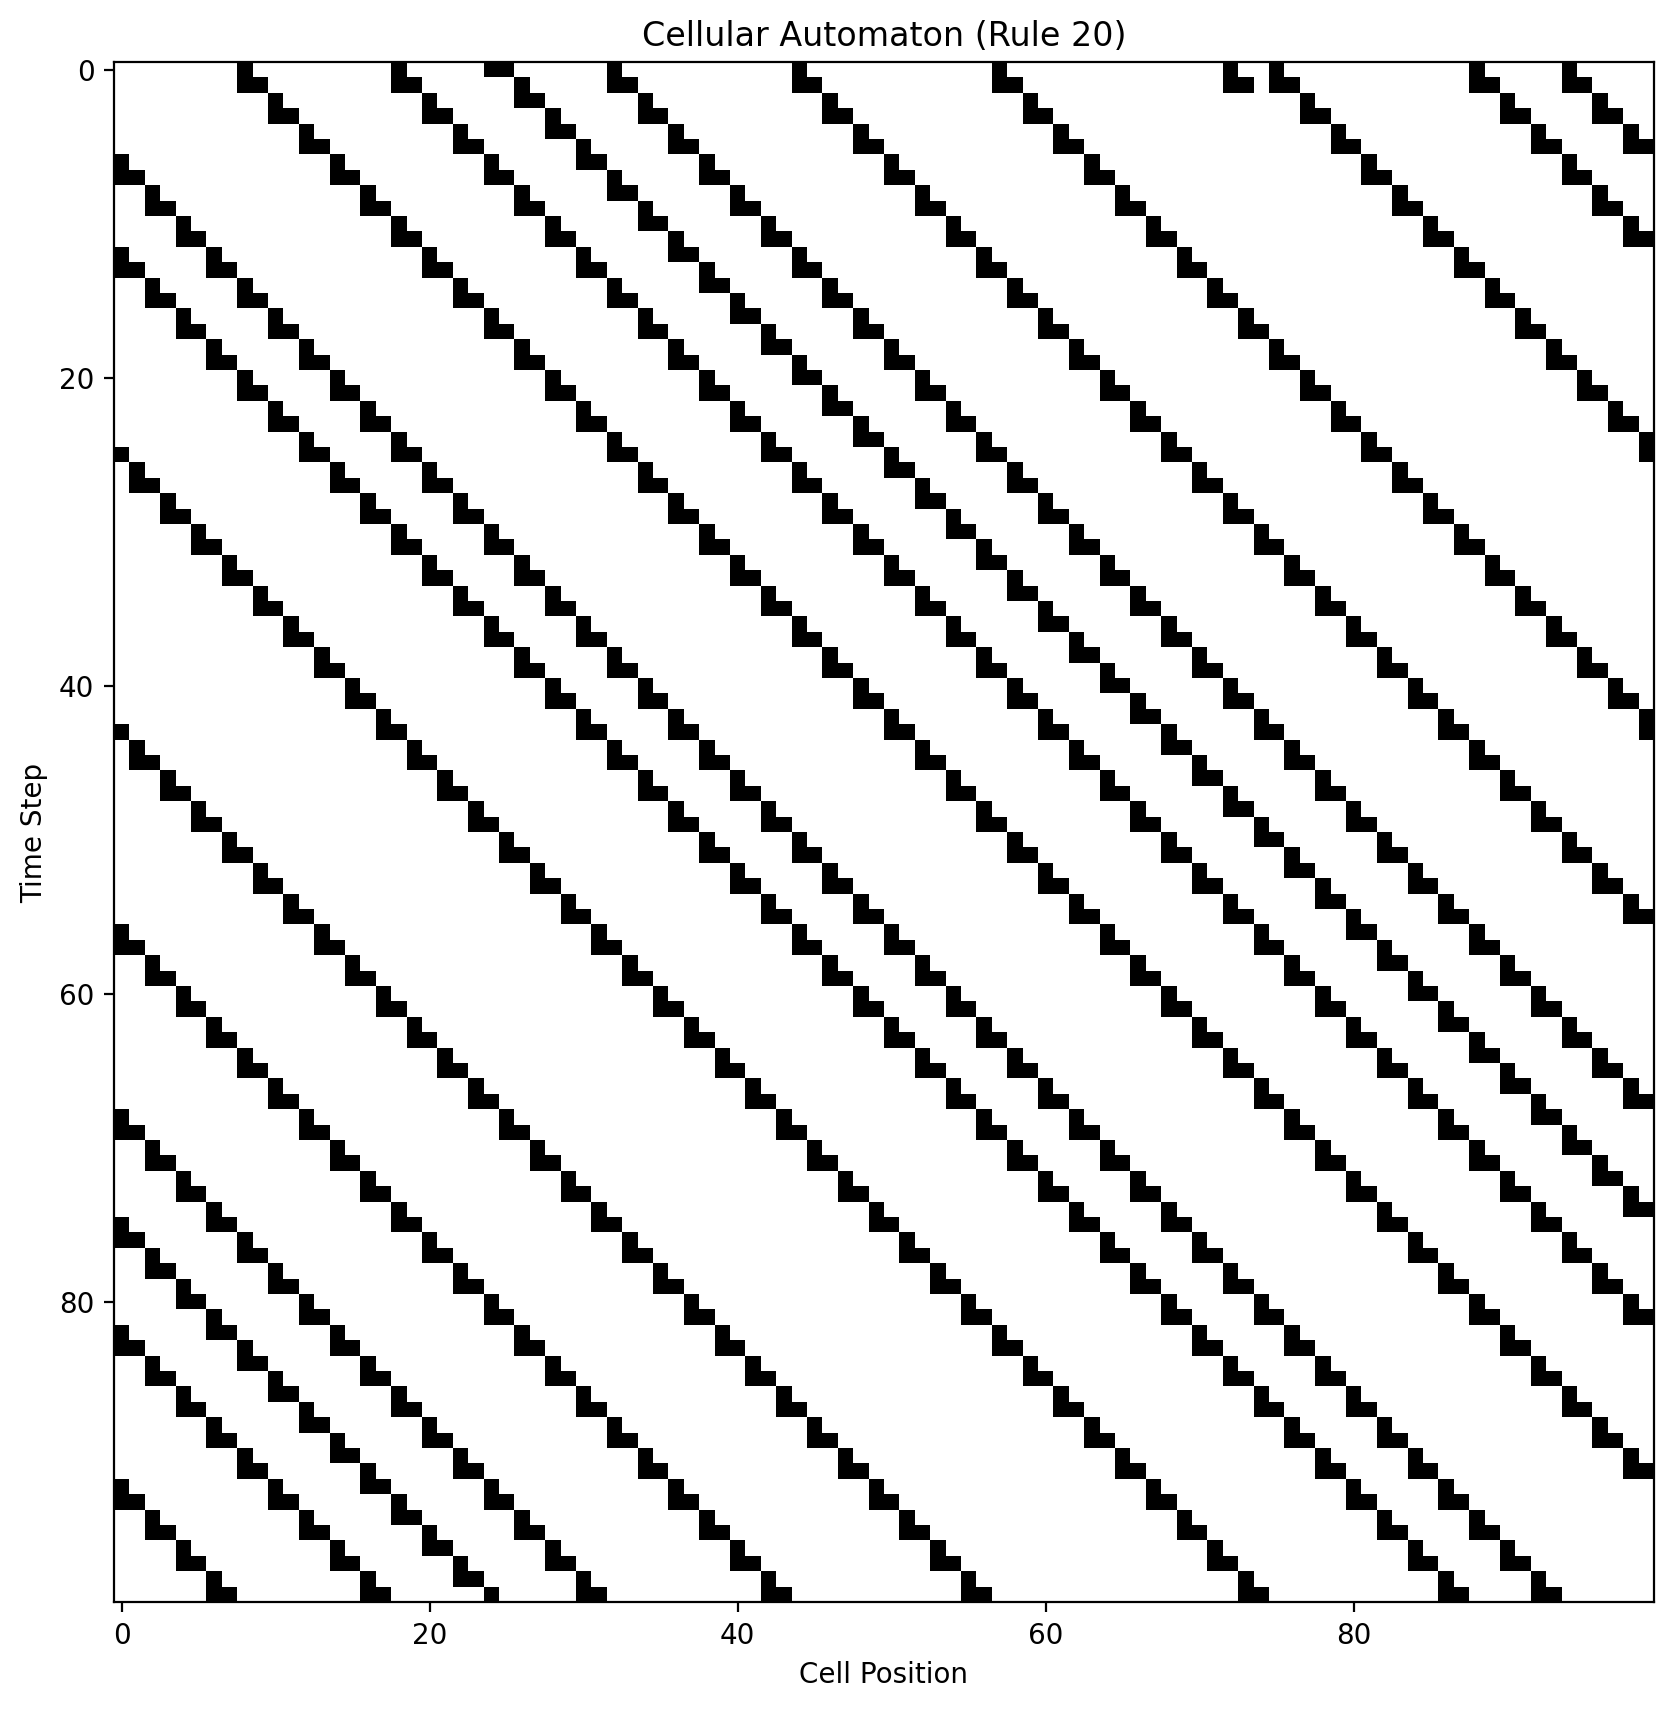

MIDI file 'ca_music.mid' generated with Rule 20 and played.


In [3]:
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt
from music21 import stream, midi
import random
%matplotlib inline

# Cellular automaton parameters
WIDTH = 100
STEPS = 100

# Musical parameters
BPM = 100
BASE_NOTE_DURATION = 0.75 # Base quarter note
C_MAJOR_SCALE = [60, 62, 64, 65, 67, 69, 71]  # C major scale (MIDI notes: C4 to B4)
VELOCITY_RANGE = (50, 120)  # Velocity range for dynamics
DURATION_OPTIONS = [0.125, 0.25, 0.5]  # Eighth, quarter, half notes

# Convert rule number to binary rule array
def get_rule_array(rule_num):
    return [int(x) for x in format(rule_num, '08b')]

# Apply cellular automaton rule
def apply_rule(left, center, right, rule_array):
    pattern = (left << 2) | (center << 1) | right
    return rule_array[7 - pattern]

# Generate cellular automaton grid with random initial seed
def generate_ca(rule_num):
    grid = np.zeros((STEPS, WIDTH), dtype=int)
    # Random initial row with 10% chance of active cells
    grid[0] = np.random.choice([0, 1], size=WIDTH, p=[0.9, 0.1])
    rule_array = get_rule_array(rule_num)
    
    for i in range(1, STEPS):
        for j in range(WIDTH):
            left = grid[i-1, (j-1) % WIDTH]
            center = grid[i-1, j]
            right = grid[i-1, (j+1) % WIDTH]
            grid[i, j] = apply_rule(left, center, right, rule_array)
    
    return grid

# Map CA grid to MIDI notes with two tracks
def grid_to_midi(grid):
    midi = MIDIFile(2, deinterleave=False)  # Disable deinterleaving to avoid IndexError
    midi.addTempo(0, 0, BPM)
    
    # Random bass offset for this run
    bass_offset = random.choice([-12, -24, -7])  # Octave down, two octaves down, or fifth down
    
    # Melody track (track 0)
    for t in range(STEPS):
        time = t * BASE_NOTE_DURATION
        for x in range(WIDTH // 2):  # Use left half of grid for melody
            if grid[t, x] == 1:
                note = random.choice(C_MAJOR_SCALE)
                velocity = random.randint(VELOCITY_RANGE[0], VELOCITY_RANGE[1]) + (x % 10)
                velocity = min(velocity, 127)
                duration = random.choice(DURATION_OPTIONS)
                midi.addNote(0, 0, note, time, duration, velocity)  # Note-on
                midi.addNote(0, 0, note, time + duration, 0, velocity)  # Note-off
    
    # Bass track (track 1)
    for t in range(STEPS):
        time = t * BASE_NOTE_DURATION
        for x in range(WIDTH // 2, WIDTH):  # Use right half of grid for bass
            if grid[t, x] == 1:
                note = random.choice(C_MAJOR_SCALE) + bass_offset
                velocity = random.randint(VELOCITY_RANGE[0], VELOCITY_RANGE[1]) - (x % 10)
                velocity = max(velocity, 1)
                duration = random.choice(DURATION_OPTIONS) * 2
                midi.addNote(1, 1, note, time, duration, velocity)  # Note-on
                midi.addNote(1, 1, note, time + duration, 0, velocity)  # Note-off
    
    return midi

# Convert MIDI to music21 stream for playback
def midi_to_stream(midi_file):
    with open("ca_music.mid", "wb") as f:
        midi_file.writeFile(f)
    mf = midi.MidiFile()
    mf.open("ca_music.mid")
    mf.read()
    mf.close()
    return midi.translate.midiFileToStream(mf)

# Visualize CA grid
def plot_ca_grid(grid, rule_num):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='binary', interpolation='nearest')
    plt.title(f"Cellular Automaton (Rule {rule_num})")
    plt.xlabel("Cell Position")
    plt.ylabel("Time Step")
    plt.show()

# Main execution
def main():
    # Get user input for CA rule
    while True:
        try:
            rule_num = int(input("Enter a Wolfram rule number (0–255): "))
            if 0 <= rule_num <= 255:
                break
            else:
                print("Please enter a number between 0 and 255.")
        except ValueError:
            print("Invalid input. Please enter a valid integer.")
    
    # Generate and display CA grid
    grid = generate_ca(rule_num)
    plot_ca_grid(grid, rule_num)
    
    # Generate MIDI and play
    midi = grid_to_midi(grid)
    score = midi_to_stream(midi)
    score.show('midi')  # Plays MIDI in Jupyter if music21 is configured
    print(f"MIDI file 'ca_music.mid' generated with Rule {rule_num} and played.")

if __name__ == "__main__":
    main()
    